# 特征工程

In [1]:
# import sys
# sys.path.append('/home/aistudio/external-libraries')
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
%matplotlib inline
plt.rc('font', family='SimHei', size=13)
import seaborn as sns

import datetime
from tqdm import tqdm
from collections import defaultdict  

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss

import pickle as cPickle

## 1. 读取数据

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./testA.csv')
train.shape + test.shape

(800000, 47, 200000, 46)

In [3]:
numerical_features_train = list(train.select_dtypes(include=[np.number]).columns)
categorical_features_train = list(train.select_dtypes(include=['object']).columns)

numerical_features_test = list(test.select_dtypes(include=[np.number]).columns)
categorical_features_test = list(test.select_dtypes(include=['object']).columns)
numerical_features_test + [ "////////"  ]+ categorical_features_test

['id',
 'loanAmnt',
 'term',
 'interestRate',
 'installment',
 'employmentTitle',
 'homeOwnership',
 'annualIncome',
 'verificationStatus',
 'purpose',
 'postCode',
 'regionCode',
 'dti',
 'delinquency_2years',
 'ficoRangeLow',
 'ficoRangeHigh',
 'openAcc',
 'pubRec',
 'pubRecBankruptcies',
 'revolBal',
 'revolUtil',
 'totalAcc',
 'initialListStatus',
 'applicationType',
 'title',
 'policyCode',
 'n0',
 'n1',
 'n2',
 'n3',
 'n4',
 'n5',
 'n6',
 'n7',
 'n8',
 'n9',
 'n10',
 'n11',
 'n12',
 'n13',
 'n14',
 '////////',
 'grade',
 'subGrade',
 'employmentLength',
 'issueDate',
 'earliesCreditLine']

## 2.过滤特征

In [4]:
loan_numeric = train[numerical_features_train]
corr = loan_numeric.corr()

threshold = 0.5
corr_list = []
size = corr.shape[0]

for i in range(0, size): 
    for j in range(i+1,size): 
        if (corr.iloc[i,j] >= threshold and corr.iloc[i,j] <= 1) or (corr.iloc[i,j] < 0 and corr.iloc[i,j] <= -threshold):
            corr_list.append([corr.iloc[i,j],i,j]) 
          
s_corr_list = sorted(corr_list,key=lambda x: -abs(x[0]))
for v,i,j in s_corr_list:
    print ("%s and %s = %.2f" % (numerical_features_train[i],numerical_features_train[j],v))

n2 and n3 = 1.00
ficoRangeLow and ficoRangeHigh = 1.00
openAcc and n10 = 1.00
n2 and n9 = 0.98
n3 and n9 = 0.98
loanAmnt and installment = 0.95
n5 and n8 = 0.84
openAcc and n7 = 0.83
n7 and n10 = 0.83
n1 and n4 = 0.83
n1 and n2 = 0.81
n1 and n3 = 0.81
n1 and n9 = 0.80
n7 and n9 = 0.79
n2 and n7 = 0.79
n3 and n7 = 0.79
n7 and n8 = 0.77
totalAcc and n8 = 0.76
n4 and n7 = 0.74
n4 and n5 = 0.72
openAcc and totalAcc = 0.70
totalAcc and n10 = 0.70
totalAcc and n6 = 0.68
n2 and n4 = 0.66
n3 and n4 = 0.66
openAcc and n9 = 0.66
n9 and n10 = 0.66
delinquency_2years and n13 = 0.66
openAcc and n2 = 0.66
openAcc and n3 = 0.66
n2 and n10 = 0.66
n3 and n10 = 0.66
n1 and n7 = 0.65
openAcc and n8 = 0.65
pubRec and pubRecBankruptcies = 0.64
n8 and n10 = 0.64
n4 and n9 = 0.64
totalAcc and n5 = 0.62
n5 and n7 = 0.62
openAcc and n4 = 0.62
n4 and n10 = 0.61
n1 and n5 = 0.58
n4 and n8 = 0.57
n2 and n8 = 0.57
n3 and n8 = 0.57
n8 and n9 = 0.56
totalAcc and n7 = 0.56
openAcc and n1 = 0.54
n1 and n10 = 0.54
open

In [ ]:
loan_numeric = test[numerical_features_test]
corr = loan_numeric.corr()

threshold = 0.5
corr_list = []
size = corr.shape[0]

for i in range(0, size): 
    for j in range(i+1,size): 
        if (corr.iloc[i,j] >= threshold and corr.iloc[i,j] <= 1) or (corr.iloc[i,j] < 0 and corr.iloc[i,j] <= -threshold):
            corr_list.append([corr.iloc[i,j],i,j]) 
          
s_corr_list = sorted(corr_list,key=lambda x: -abs(x[0]))
for v,i,j in s_corr_list:
    print ("%s and %s = %.2f" % (numerical_features_test[i],numerical_features_test[j],v))

从以上train和test的相关系数结果看出，openAcc和n10的相关系数是1，去掉n10;
n2和n9相关系数0.98，因此去掉n9, 再合并测试集和训练集做特征工程。

In [6]:
train.drop(["n9"], axis=1, inplace=True)
train.drop('n10', axis=1, inplace=True)
test.drop(['n9','n10'], axis=1, inplace=True)
data = pd.concat([train, test], ignore_index=True)
data.columns


Index(['id', 'loanAmnt', 'term', 'interestRate', 'installment', 'grade',
       'subGrade', 'employmentTitle', 'employmentLength', 'homeOwnership',
       'annualIncome', 'verificationStatus', 'issueDate', 'isDefault',
       'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years',
       'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec',
       'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc',
       'initialListStatus', 'applicationType', 'earliesCreditLine', 'title',
       'policyCode', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8',
       'n11', 'n12', 'n13', 'n14'],
      dtype='object')

In [7]:
numerical_features_test

['id',
 'loanAmnt',
 'term',
 'interestRate',
 'installment',
 'employmentTitle',
 'homeOwnership',
 'annualIncome',
 'verificationStatus',
 'purpose',
 'postCode',
 'regionCode',
 'dti',
 'delinquency_2years',
 'ficoRangeLow',
 'ficoRangeHigh',
 'openAcc',
 'pubRec',
 'pubRecBankruptcies',
 'revolBal',
 'revolUtil',
 'totalAcc',
 'initialListStatus',
 'applicationType',
 'title',
 'policyCode',
 'n0',
 'n1',
 'n2',
 'n3',
 'n4',
 'n5',
 'n6',
 'n7',
 'n8',
 'n9',
 'n10',
 'n11',
 'n12',
 'n13',
 'n14']

In [8]:
data.shape

(1000000, 45)

## 3. 处理缺失值

In [9]:
missing = data.isnull().sum()
missing = missing[missing > 0]
missing.sort_values()
missing

employmentTitle            1
employmentLength       58541
isDefault             200000
postCode                   1
dti                      300
pubRecBankruptcies       521
revolUtil                658
title                      1
n0                     50381
n1                     50381
n2                     50381
n3                     50381
n4                     41633
n5                     50381
n6                     50381
n7                     50381
n8                     50382
n11                    87327
n12                    50381
n13                    50381
n14                    50381
dtype: int64

In [10]:
numerical_features_all = list(data.select_dtypes(include=[np.number]).columns)
categorical_features_all = list(data.select_dtypes(include=['object']).columns)
# numerical_features_all
categorical_features_all

['grade', 'subGrade', 'employmentLength', 'issueDate', 'earliesCreditLine']

In [11]:
# 处理 employmentLength
def employmentLength_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
    
data['employmentLength'].replace(to_replace='10+ years', value='10 years', inplace=True)
data['employmentLength'].replace('< 1 year', '0 years', inplace=True)
data['employmentLength'].value_counts(dropna=False).sort_index()   
data['employmentLength'] = data['employmentLength'].apply(employmentLength_to_int)

In [12]:
# 缺失值填充
data['employmentLength'] = data['employmentLength'].fillna(data['employmentLength'].median())
data[numerical_features_all] = data[numerical_features_all].fillna(data[numerical_features_all].median())

## 3. 处理时间相关特征

In [13]:
# 处理issueDate
data['issueDate'] = pd.to_datetime(data['issueDate'], format='%Y-%m-%d')
startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
data['issueDateDT'] = data['issueDate'].apply(lambda x: x-startdate).dt.days
data['issueMonth'] = pd.to_datetime(data['issueDate']).dt.month
data['issueYear'] = pd.to_datetime(data['issueDate']).dt.year

# 处理earliesCreditLine
dict_month = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, "Dec": 12}
data['earliesCredit_year'] = data['earliesCreditLine'].apply(lambda x: int(x[-4:]))
data['earliesCredit_month'] = data['earliesCreditLine'].apply(lambda x : dict_month[x[:3]])
data.drop('earliesCreditLine', axis=1, inplace=True)

In [17]:
testpd = pd.read_csv('./testA.csv')
data.head()

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,verificationStatus,issueDate,isDefault,purpose,postCode,regionCode,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,applicationType,title,policyCode,n0,n1,n2,n3,n4,n5,n6,n7,n8,n11,n12,n13,n14,issueDateDT,issueMonth,issueYear,earliesCredit_year,earliesCredit_month
0,0,35000.0,5,19.52,917.97,E,E2,320.0,2.0,2,110000.0,2,2014-07-01,1.0,1,137.0,32,17.05,0.0,730.0,734.0,7.0,0.0,0.0,24178.0,48.9,27.0,0,0,1.0,1.0,0.0,2.0,2.0,2.0,4.0,9.0,8.0,4.0,12.0,0.0,0.0,0.0,2.0,2587,7,2014,2001,8
1,1,18000.0,5,18.49,461.90,D,D2,219843.0,5.0,0,46000.0,2,2012-08-01,0.0,0,156.0,18,27.83,0.0,700.0,704.0,13.0,0.0,0.0,15096.0,38.9,18.0,1,0,1723.0,1.0,0.0,3.0,5.0,5.0,10.0,7.0,7.0,7.0,13.0,0.0,0.0,0.0,2.0,1888,8,2012,2002,5
2,2,12000.0,5,16.99,298.17,D,D3,31698.0,8.0,0,74000.0,2,2015-10-01,0.0,0,337.0,14,22.77,0.0,675.0,679.0,11.0,0.0,0.0,4606.0,51.8,27.0,0,0,0.0,1.0,0.0,0.0,3.0,3.0,0.0,0.0,21.0,4.0,5.0,0.0,0.0,0.0,4.0,3044,10,2015,2006,5
3,3,11000.0,3,7.26,340.96,A,A4,46854.0,10.0,1,118000.0,1,2015-08-01,0.0,4,148.0,11,17.21,0.0,685.0,689.0,9.0,0.0,0.0,9948.0,52.6,28.0,1,0,4.0,1.0,6.0,4.0,6.0,6.0,4.0,16.0,4.0,7.0,21.0,0.0,0.0,0.0,1.0,2983,8,2015,1999,5
4,4,3000.0,3,12.99,101.07,C,C2,54.0,6.0,1,29000.0,2,2016-03-01,0.0,10,301.0,21,32.16,0.0,690.0,694.0,12.0,0.0,0.0,2942.0,32.0,27.0,0,0,11.0,1.0,1.0,2.0,7.0,7.0,2.0,4.0,9.0,10.0,15.0,0.0,0.0,0.0,4.0,3196,3,2016,1977,8


## 4. 处理异常值

Delete number is: 22802
Now column number is: 977198
Description of data less than the lower bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: revolBal, dtype: float64
Description of data larger than the upper bound is:
count    2.280200e+04
mean     1.142716e+05
std      8.312126e+04
min      6.114600e+04
25%      7.082950e+04
50%      8.767200e+04
75%      1.255055e+05
max      2.904836e+06
Name: revolBal, dtype: float64


findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.


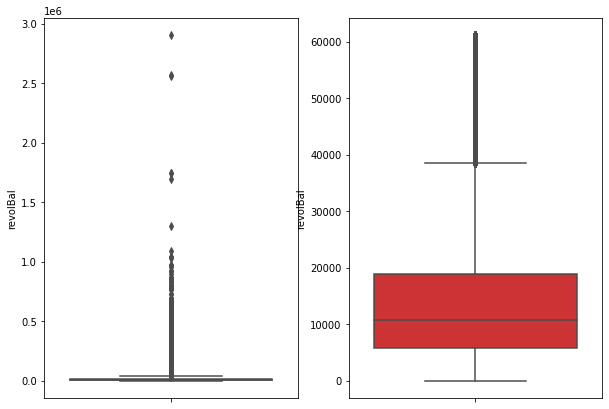

In [19]:
# 封装了一个异常值处理的代码，可以随便调用。
def outliers_proc(data, col_name, scale=3):
    """
    用于清洗异常值，默认用 box_plot（scale=3）进行清洗
    :param data: 接收 pandas 数据格式
    :param col_name: pandas 列名
    :param scale: 尺度
    :return:
    """

    def box_plot_outliers(data_ser, box_scale):
        """
        利用箱线图去除异常值
        :param data_ser: 接收 pandas.Series 数据格式
        :param box_scale: 箱线图尺度，
        :return:
        """
        iqr = box_scale * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
        val_low = data_ser.quantile(0.25) - iqr
        val_up = data_ser.quantile(0.75) + iqr
        rule_low = (data_ser < val_low)
        rule_up = (data_ser > val_up)
        return (rule_low, rule_up), (val_low, val_up)

    data_n = data.copy()
    data_series = data_n[col_name]
    rule, value = box_plot_outliers(data_series, box_scale=scale)
    index = np.arange(data_series.shape[0])[rule[0] | rule[1]]
    print("Delete number is: {}".format(len(index)))
    data_n = data_n.drop(index)
    data_n.reset_index(drop=True, inplace=True)
    print("Now column number is: {}".format(data_n.shape[0]))
    index_low = np.arange(data_series.shape[0])[rule[0]]
    outliers = data_series.iloc[index_low]
    print("Description of data less than the lower bound is:")
    print(pd.Series(outliers).describe())
    index_up = np.arange(data_series.shape[0])[rule[1]]
    outliers = data_series.iloc[index_up]
    print("Description of data larger than the upper bound is:")
    print(pd.Series(outliers).describe())
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 7))
    sns.boxplot(y=data[col_name], data=data, palette="Set1", ax=ax[0])
    sns.boxplot(y=data_n[col_name], data=data_n, palette="Set1", ax=ax[1])
    return data_n

# 删掉一些异常数据，但是要注意 test 的数据不能删
data = outliers_proc(data, 'revolBal', scale=3)

In [ ]:
# When we reset the index, the old index is added as a column, and a new sequential index is used:

# df.reset_index()
#     index   class  max_speed
# 0  falcon    bird      389.0
# 1  parrot    bird       24.0
# 2    lion  mammal       80.5
# 3  monkey  mammal        NaN
# We can use the drop parameter to avoid the old index being added as a column:

# df.reset_index(drop=True)
#     class  max_speed
# 0    bird      389.0
# 1    bird       24.0
# 2  mammal       80.5
# 3  mammal        NaN

In [34]:
testpd.sort_index(ascending=True)
# df.sort_index(ascending=False)
testpd.head()

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,verificationStatus,issueDate,purpose,postCode,regionCode,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,applicationType,earliesCreditLine,title,policyCode,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
0,800000,14000.0,3,10.99,458.28,B,B3,7027.0,10+ years,0,80000.0,0,2014-07-01,0,163.0,21,10.56,1.0,715.0,719.0,17.0,0.0,0.0,9846.0,30.7,29.0,0,0,Nov-1974,0.0,1.0,1.0,4.0,6.0,6.0,6.0,8.0,4.0,15.0,19.0,6.0,17.0,0.0,0.0,1.0,3.0
1,800001,20000.0,5,14.65,472.14,C,C5,60426.0,10+ years,0,50000.0,0,2015-07-01,2,235.0,8,21.40,2.0,670.0,674.0,5.0,0.0,0.0,8946.0,56.6,14.0,0,0,Jul-2001,5.0,1.0,2.0,1.0,3.0,3.0,1.0,1.0,3.0,3.0,9.0,3.0,5.0,0.0,0.0,2.0,2.0
2,800002,12000.0,3,19.99,445.91,D,D4,23547.0,2 years,1,60000.0,2,2016-10-01,0,526.0,20,33.50,0.0,710.0,714.0,12.0,0.0,0.0,970.0,17.6,43.0,1,0,Aug-2006,0.0,1.0,0.0,1.0,4.0,4.0,1.0,1.0,36.0,5.0,6.0,4.0,12.0,0.0,0.0,0.0,7.0
3,800003,17500.0,5,14.31,410.02,C,C4,636.0,4 years,0,37000.0,1,2014-11-01,4,248.0,11,13.95,0.0,685.0,689.0,10.0,1.0,1.0,10249.0,52.3,18.0,0,0,Jul-2002,4.0,1.0,0.0,2.0,2.0,2.0,4.0,7.0,2.0,8.0,14.0,2.0,10.0,0.0,0.0,0.0,3.0
4,800004,35000.0,3,17.09,1249.42,D,D1,368446.0,< 1 year,1,80000.0,1,2017-10-01,0,115.0,8,24.97,0.0,685.0,689.0,19.0,0.0,0.0,33199.0,35.6,22.0,0,0,Dec-2000,0.0,1.0,0.0,8.0,11.0,11.0,9.0,11.0,3.0,16.0,18.0,11.0,19.0,0.0,0.0,0.0,1.0


## 5. 增加统计特征

In [24]:
# LabelEncoder编码
from sklearn.preprocessing import LabelEncoder
encoder_list = ['grade', 'subGrade','employmentTitle', 'postCode', 'title','regionCode']
for one in encoder_list:
    encoder = LabelEncoder()
    encoder.fit(data[one])
    data[one] = encoder.transform(data[one])

In [74]:
bin = [i*100 for i in range(1, 410, 10)]
data['loanAmnt_bin'] = pd.cut(data['loanAmnt'], bin, labels=False)

bin = [i for i in range(0, 34, 3)]
data['interestRate_bin'] = pd.cut(data['interestRate'], bin, labels=False)

max_income = data['annualIncome'].max()
bin = [0, 10**3, 10**4, 5*(10**4), 10**5, 3*(10**5), 6*(10**5), 10**6, 3*(10**6), 6*(10**6), max_income+1]
data['annualIncome_bin'] = pd.cut(data['annualIncome'], bin, labels=False, include_lowest=True, right=False)
#   with out right=False  (1.0, 3.0]
#   with right=False      [1, 3)
data['installment_bin'] = pd.cut(data['installment'], 40, labels=False)

bin = [-1.0, 2.0, 5.0, 40]
data['delinquency_2years_bin'] = pd.cut(data['delinquency_2years'], bin, labels=False)

bin = [-1.1, 5, 10, 20, 30, 40, 50, 1000]
data['dti_bin'] = pd.cut(data['dti'], bin, labels=False, include_lowest=True, right=False)

def count_coding(df, features):
    for col in features:
        tmp = df.groupby([col]).count()['id'].to_dict()
        df[col + '_count'] = data[col].apply(lambda x: tmp[x] if not np.isnan(x) else np.nan)
    return df

# def count_coding(df,fea_col):
#     for fea in fea_col:
#         df[fea + '_count'] = df[fea].map(df[fea].value_counts())
#     return(df)
        
features_list = ['grade', 'subGrade','term', 'employmentLength',
                 'loanAmnt_bin','interestRate_bin', 'annualIncome_bin', 'installment_bin',
                 'delinquency_2years_bin','dti_bin']

data = count_coding(data, features_list)

In [68]:
# for i in range(1, 410, 10):
#   print(i*100)
# pd.cut(np.array([1, 7, 5, 4, 6, 3]), 3)
# np.array([1, 7, 5, 4, 6, 3])


SyntaxError: ignored

In [69]:
# pd.cut(np.array([1, 7, 5, 4, 6, 3]),
#        3, labels=["bad", "medium", "good"])
bb = np.array([100, 1000, 10000, 50000, 49999, 3])
bb

array([  100,  1000, 10000, 50000, 49999,     3])

In [72]:
# pd.cut([0, 1, 1, 2], bins=4, labels=False)
# pd.cut([0, 1, 1, 2], bins=4, labels=["bad", "medium", "good", "very good"])
bintest = [1, 3, 5, 7, 9]
pd.cut(np.array([1, 7, 5, 4, 6, 3]), bintest, right=False)

[[1, 3), [7, 9), [5, 7), [3, 5), [5, 7), [3, 5)]
Categories (4, interval[int64]): [[1, 3) < [3, 5) < [5, 7) < [7, 9)]

id        item        color
01        truck       red

*   List item
*   List item


02        truck       red
03        car         black
04        truck       blue
05        car         black

In [93]:
df = pd.DataFrame([('bird', 389.0),
                   ('bird', 24.0),
                   ('mammal', 80.5),
                   ('mammal', np.nan)],
                  index=['falcon', 'parrot', 'lion', 'monkey'],
                  columns=('class', 'max_speed'))
df2 = pd.DataFrame([(1, 'truck',       'red'),
                   (2,       'truck',       'red'),
                   (3,        'car',         'black'),
                   (4, 'truck', 'blue'),
                   (5,'car',    'black')],
                  columns=('id','class', 'max_speed'))
df2.groupby(['class']).count()['id'].to_dict()


{'car': 2, 'truck': 3}

## 6. 特征交叉

In [76]:
# 对匿名特征做特征交叉
n_features = [0,1,2,4,5,6,7,8,11,12,13,14]
for i in n_features:
    for j in n_features[i:]:
        data['new' + str(i) + '+' + str(j)] = data['n' + str(i)] + data['n' + str(j)]
        
for i in n_features:
    for j in n_features[i:]:
        data['new' + str(i) + '*' + str(j)] = data['n' + str(i)] * data['n' + str(j)]        

In [ ]:
import itertools

corr = data.corr(method='spearman')
feature_group = list(itertools.combinations(corr.columns, 2))
print(feature_group)

# 删除相关性高的变量
def filter_corr(corr, cutoff=0.7):
    cols = []
    for i,j in feature_group:
        if corr.loc[i, j] > cutoff:
            print(i,j,corr.loc[i, j])
            i_avg = corr[i][corr[i] != 1].mean()
            j_avg = corr[j][corr[j] != 1].mean()
            if i_avg >= j_avg:
                cols.append(i)
            else:
                cols.append(j)
    return set(cols)

drop_cols = filter_corr(corr, cutoff=0.95)
print(drop_cols)

## 7. 特征编码

In [ ]:
# LabelEncoder编码
# from sklearn.preprocessing import LabelEncoder
# encoder_list = ['grade', 'subGrade','employmentTitle', 'postCode', 'title','regionCode']
# for one in encoder_list:
#     encoder = LabelEncoder()
#     encoder.fit(data[one])
#     data[one] = encoder.transform(data[one])
    
# 独热编码
data = pd.get_dummies(data, columns=['homeOwnership', 'verificationStatus', 'purpose'])
data.columns

Index(['annualIncome', 'applicationType', 'delinquency_2years', 'dti',
       'employmentLength', 'employmentTitle', 'ficoRangeHigh', 'ficoRangeLow',
       'grade', 'id', 'initialListStatus', 'installment', 'interestRate',
       'isDefault', 'issueDate', 'loanAmnt', 'n0', 'n1', 'n11', 'n12', 'n13',
       'n14', 'n2', 'n4', 'n5', 'n6', 'n7', 'n8', 'openAcc', 'policyCode',
       'postCode', 'pubRec', 'pubRecBankruptcies', 'regionCode', 'revolBal',
       'revolUtil', 'subGrade', 'term', 'title', 'totalAcc', 'issueDateDT',
       'issueMonth', 'issueYear', 'earliesCredit_year', 'earliesCredit_month',
       'loanAmnt_bin', 'interestRate_bin', 'annualIncome_bin',
       'installment_bin', 'delinquency_2years_bin', 'dti_bin', 'grade_count',
       'subGrade_count', 'term_count', 'employmentLength_count',
       'loanAmnt_bin_count', 'interestRate_bin_count',
       'annualIncome_bin_count', 'installment_bin_count',
       'delinquency_2years_bin_count', 'dti_bin_count', 'homeOwnership_0

## 8、特征选择
包裹式

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 84 columns):
annualIncome                    1000000 non-null float64
applicationType                 1000000 non-null int64
delinquency_2years              1000000 non-null float64
dti                             1000000 non-null float64
employmentLength                1000000 non-null float64
employmentTitle                 1000000 non-null int64
ficoRangeHigh                   1000000 non-null float64
ficoRangeLow                    1000000 non-null float64
grade                           1000000 non-null int64
id                              1000000 non-null int64
initialListStatus               1000000 non-null int64
installment                     1000000 non-null float64
interestRate                    1000000 non-null float64
isDefault                       1000000 non-null float64
issueDate                       1000000 non-null datetime64[ns]
loanAmnt                        1000

In [ ]:
train = data[:train.shape[0]]
X = train.drop(['isDefault','issueDate'], axis=1)
y = train['isDefault']

In [ ]:
# k_feature 太大会很难跑，没服务器，所以放弃
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression
sfs = SFS(LogisticRegression(),
           k_features=10,
           forward=True,
           floating=False,
           scoring = 'roc_auc',
           cv = 0)
sfs.fit(X, y)
sfs.k_feature_names_ 

('dti',
 'ficoRangeHigh',
 'n14',
 'n2',
 'subGrade',
 'term',
 'issueDateDT',
 'annualIncome_bin',
 'installment_bin',
 'homeOwnership_0')

In [ ]:
from sklearn import metrics
print(metrics.SCORERS.keys())

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


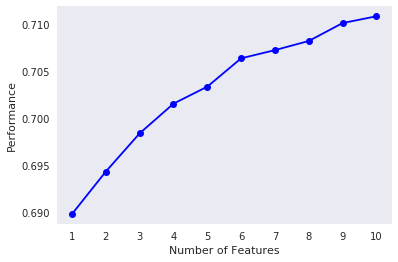

In [ ]:
# 画出来，可以看到边际效益
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.grid()
plt.show()

嵌入式

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
# GBDT作为基模型的特征选择
sfm = SelectFromModel(GradientBoostingClassifier())
sfm.fit(X, y)
n_selected_feats = sfm.transform(X).shape[1]
n_selected_feats

15

## 9. 特征归一化

In [ ]:
label = 'isDefault'
numerical_features_all.remove(label)

# 划分数值型变量中的连续变量和离散型变量
def get_numerical_serial_fea(data,feas):
    numerical_serial_fea = []
    numerical_noserial_fea = []
    for fea in feas:
        temp = data[fea].nunique()
        if temp <= 10:
            numerical_noserial_fea.append(fea)
            continue
        numerical_serial_fea.append(fea)
    return numerical_serial_fea, numerical_noserial_fea

numerical_serial_fea, numerical_noserial_fea = get_numerical_serial_fea(data, numerical_features_all)

cate_features = ['grade', 'subGrade', 'employmentTitle', 'homeOwnership', 'verificationStatus', 'purpose', 'postCode', 'regionCode', \
                 'applicationType', 'initialListStatus', 'title', 'policyCode']
for f in cate_features:
    print(f, '类型数：', data[f].nunique())

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

for col in numerical_serial_fea:
    min_max_scaler = MinMaxScaler()
    min_max_scaler.fit_transform(pd.DataFrame(data=data[col], columns=[col]))

## 10. 保存处理好的特征

In [ ]:
train = data[:train.shape[0]]
test = data[train.shape[0]:]
train.to_csv('../train_data_v1.csv', index=False)
test.to_csv('../test_data_v1.csv', index=False)